In [5]:
from pynq import Overlay
from pynq import MMIO
from pynq import allocate
import pynq.lib.dma
import numpy as np
import cv2
%matplotlib inline
import matplotlib . pyplot as plt
import time

In [6]:
base = Overlay("assets/design_1.bit")
dir(base)

['MNIST_0',
 'PSDDR',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deepcopy_dict_from',
 '_ip_map',
 '_register_drivers',
 'axi_dma_0',
 'axi_dma_1',
 'axi_intc_0',
 'axi_timer_0',
 'binfile_name',
 'bit_data',
 'bitfile_name',
 'clock_dict',
 'device',
 'download',
 'dtbo',
 'firmware_path',
 'free',
 'gen_cache',
 'gpio_dict',
 'hierarchy_dict',
 'ignore_version',
 'insert_dtbo',
 'interrupt_controllers',
 'interrupt_pins',
 'ip_dict',
 'is_loaded',
 'load_ip_data',
 'mem_dict',
 'parser',
 'partial',
 'pr_dict',
 'pr_download',
 'remove_dtbo',
 'reset',
 'systemgraph',
 'timestamp',
 'zynq_ultra_ps_e_0']

In [7]:
dma0 = base.axi_dma_0
dma1 = base.axi_dma_1
registers = base.MNIST_0.register_map

In [8]:
import struct
def float_to_int(f):
    packed = struct.pack('>f', f)
    unpacked = struct.unpack('>I', packed)[0]
    return unpacked

def int_to_float(i):
    packed = struct.pack('>I', i)
    unpacked = struct.unpack('>f', packed)[0]
    return unpacked


In [9]:
input_buffer = allocate(shape=(28 * 28), dtype=np.uint32, cacheable=False)
output_buffer = allocate(shape=(10), dtype=np.uint32, cacheable=False)

In [10]:
import json
params = json.load(open("assets/params.json"))
depth1 = params['conv1_depthwise']
point1 = params['conv1_pointwise']
depth2 = params['conv2_depthwise']
point2 = params['conv2_pointwise']
depth3 = params['conv3_depthwise']
point3 = params['conv3_pointwise']

depth1 = [float_to_int(item) for row2 in depth1 for row in row2 for item in row]
depth2 = [float_to_int(item) for row2 in depth2 for row in row2 for item in row]
depth3 = [float_to_int(item) for row2 in depth3 for row in row2 for item in row]
point1 = [float_to_int(item) for row in point1 for item in row]
point2 = [float_to_int(item) for row in point2 for item in row]
point3 = [float_to_int(item) for row in point3 for item in row]

params = depth1 + point1 + depth2 + point2 + depth3 + point3
param_buffer[:] = params[:]
param_buffer.flush()

In [11]:
registers.CTRL.AP_START = 1
registers.CTRL.AUTO_RESTART = 1

In [12]:
images = json.load(open("assets/images.json"))
labels = json.load(open("assets/labels.json"))    

In [13]:
import time
t0 = time.time()
total_correct = 0
total_num = 0
for image, label in zip(images, labels):
    input_buffer[:] = image[:]
    input_buffer.flush()    
    dma0.sendchannel.transfer(input_buffer)
    dma1.sendchannel.transfer(param_buffer)
    dma0.recvchannel.transfer(output_buffer)
    dma0.sendchannel.wait()
    dma1.sendchannel.wait()
    dma0.recvchannel.wait()
    res = list(output_buffer)
    res = [int_to_float(i) for i in res]
    pred = res.index(max(res))
    # print(pred, label)
    total_correct += (pred == label)
    total_num += 1
t1 = time.time()
print("Total elapsed time:", t1-t0, "s")
print("Elapsed time per picture:", ((t1-t0) / total_num) * 1000, "ms")
print('Accuracy:', total_correct / float(total_num))

Total elapsed time: 0.9031553268432617 s
Elapsed time per picture: 0.8819876238703728 ms
Accuracy: 0.9052734375


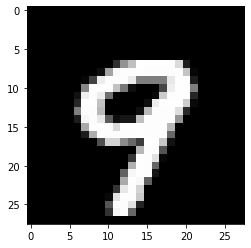

In [14]:
def imshow(img):
    img = img / 2 + 0.     # unnormalize
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
image_example = images[0]
image_example = np.array([int_to_float(i) for i in image_example])
image_example = image_example.reshape([28, 28])
imshow(image_example)